### Piecemeal Clustering
A clustering approach without prior knowledge about data even number of clusters. It uses similarity and density of data to define number of clusters. 

### Reading the Paper
#### Introduction
- No noise: KMeans, SOM
- Density-based: DBSCAN
- Precedents: trial and errors, combinations of multiple methods
- What is lithofaces, 
- The algorithm utilizes the density-based clustering combining the concepts of hierachical clustering, model-based unsupervised learning and density-based data clustering. 

### Reference:
- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9980364

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from sklearn import datasets
from scipy.cluster import hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [91]:
X, y = datasets.load_iris(as_frame=True, return_X_y=True)

In [97]:
X = X.to_numpy()
y = y.to_numpy()
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [98]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Min scaled X: {np.min(X, axis=0)}")
print(f"Max scaled X: {np.max(X, axis=0)}")

Shape of X: (150, 4)
Shape of y: (150,)
Min scaled X: [0. 0. 0. 0.]
Max scaled X: [1. 1. 1. 1.]


Text(0.5, 1.0, 'Iris Flower (PCA)')

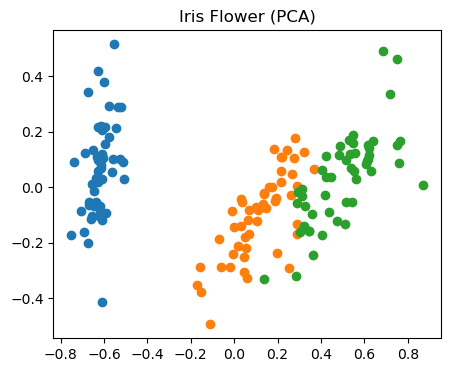

In [99]:
pca = PCA(n_components=2).fit(X)
X_r = pca.transform(X)
plt.figure(figsize=(5, 4))
for i in np.unique(y):
    t = X_r[y == i]
    plt.scatter(t[:,0], t[:,1])
plt.title("Iris Flower (PCA)")

### Structure

In [100]:
class DataPoint:
    def __init__(self, id, x, y):
        self.x = x
        self.y = y
        self.id = id


class ClusterMapping:
    def __init__(self, data: List[DataPoint]):
        self.data = data
        self.id2c = {}

        for d in self.data:
            self.id2c[d.id] = d.id # Init cluster index = d.id

    def get_clusters_items(self):
        clusters = {}
        for d in self.data:
            cluster_index = self.id2c[d.id]
            if cluster_index not in clusters:
                clusters[cluster_index] = [d]
            else:
                clusters[cluster_index].append(d)

        return clusters
    
    def get_clusters_labels(self):
        clusters = self.get_clusters_items()
        mapping = {}
        for c, items in clusters.items():
            labels = [d.y for d in items]
            vals, counts = np.unique(labels, return_counts=True)
            index = np.argmax(counts)
            mode = vals[index]
            mapping[c] = mode
        return mapping
    
    def remap_cluster_indices(self, cluster_centers: dict, diff_factor: float):
        center_vals = np.array(list(cluster_centers.values()))
        max_e = max(sch.distance.pdist(center_vals, metric="euclid"))
        max_c = -9999
        alpha = 1 / (1 + diff_factor)

        for center in center_vals:
            tmp = max([sch.distance.pdist([center, d.x], metric="cosine") for d in self.data])
            max_c = max(max_c, tmp)

        for d in self.data:
            min_delta = 99999
            best_cluster = -1
            for cluster, center in cluster_centers.items():
                e_ij = sch.distance.pdist([center, d.x], metric="euclid") / max_e
                c_ij = sch.distance.pdist([center, d.x], metric="cosine") / max_c
                p1 = np.power((alpha * e_ij), 1 / diff_factor)
                p2 = np.power((1 - alpha) * c_ij, 1 / diff_factor)
                d_ij = np.power(p1 + p2, diff_factor)
                if d_ij < min_delta:
                    min_delta = d_ij
                    best_cluster = cluster

            # print(f"Update cluster from {self.id2c[d.id]} to {min_cluster}")
            self.id2c[d.id] = best_cluster


    def get_mapping_accuracy(self):
        clusters = self.get_clusters_items()
        mapping = self.get_clusters_labels()
        accuracy = 0
        for k, items in clusters.items():
            label = mapping[k]
            accuracy += sum([d.y == label for d in items])
        return accuracy / len(self.data)
    
    def get_items(self, cluster: int):
        items = []
        for d in self.data:
            if self.id2c[d.id] == cluster:
                items.append(d)
        return items

    def get_all_centers(self, clusters = None):
        if clusters is None:
            clusters = self.get_clusters_items()
        
        centers = {}
        for c, items in clusters.items():
            arr = np.array([x.x for x in items])
            centers[c] = arr.mean(axis=0)
        return centers
    
    def get_center(self, cluster: int):
        items = self.get_items(cluster)
        arr = np.array([x.x for x in items])
        center = arr.mean(axis=0)
        return center
    
    def merge_cluster(self, a, b) -> int:
        """Merge cluster a to b
        Args:
            a (int): Cluster index to form new cluster
            b (int): Cluster index to be moved
        Returns:
            int: number of items affected
        """
        res = 0
        clusters = self.get_clusters_items()
        for c, items in clusters.items():
            if c == a:
                res += len(items)
                for p in items:
                    self.id2c[p.id] = b
        return res

### Pre Clustering

In [92]:
def compute_dist_threshold(dmatrix, cutoff: float):
    dmin = min(dmatrix)
    dmax = max(dmatrix)
    return (1 - (dmin / dmax)) * cutoff

def compute_sim_threshold(smatrix, cutoff: float, diff_factor: float):
    dmin = min(smatrix)
    dmax = max(smatrix)
    return (1 - (dmin / dmax)) * cutoff * diff_factor

In [93]:
def pairwise_cluster_distances(cluster_map: ClusterMapping, diff_factor):
    centers = cluster_map.get_all_centers()
    centers = np.array(list(centers.values())) # n, dim
    
    dmatrix = sch.distance.pdist(X, metric="euclidean")
    smatrix = sch.distance.pdist(X, metric="cosine")
    dmax = max(dmatrix)
    smax = max(smatrix)

    dmatrix = dmatrix / dmax
    dmatrix = dmatrix ** 2
    
    smatrix = smatrix / smax
    smatrix = diff_factor * (smatrix ** 2)

    pw_cd = np.sqrt(dmatrix + smatrix)
    pw_cd = sch.distance.squareform(pw_cd)
    for i in range(len(centers)):
        pw_cd[i][i] = np.inf
    return pw_cd

In [101]:
def compute_thresholds(cluster_map: ClusterMapping, cutoff: float):
    centers = cluster_map.get_all_centers()
    centers = np.array(list(centers.values())) # n, dim

    dmatrix = sch.distance.pdist(centers, metric="euclidean")
    smatrix = sch.distance.pdist(centers, metric="cosine")

    diff_factor = 1 / dmatrix.mean()
    # diff_factor = 1 / np.linalg.norm(X, axis=1).mean()

    dt = compute_dist_threshold(dmatrix, cutoff)
    st = compute_sim_threshold(smatrix, cutoff, diff_factor)
    tds = np.sqrt(dt**2 + st**2)
    return diff_factor, tds

In [137]:
def pre_clustering(cluster_map: ClusterMapping, cutoff: float):
    centers = cluster_map.get_all_centers()
    diff_factor, tds = compute_thresholds(cluster_map, cutoff)
    pw_cd = pairwise_cluster_distances(cluster_map, diff_factor)
    while(pw_cd.min() < tds):
        index = pw_cd.argmin()
        n_centers = len(centers)
        i = int(index / n_centers)
        j = index % n_centers
        cluster_map.merge_cluster(i, j)
        pw_cd[i][j] = np.inf
        pw_cd[j][i] = np.inf
    return diff_factor

In [150]:
data = [
    DataPoint(i, x, y)
    for i, (x, y) in enumerate(zip(X, y))
]
# cutoff = 0.05
cutoff = 0.15
cluster_map = ClusterMapping(data)
diff_factor = pre_clustering(cluster_map, cutoff)

### Train Piecemeal

In [104]:
def compute_decay(step, N):
    return 1 - (step / N)

def compute_radii(W):
    dmatrix = sch.distance.pdist(W, metric="euclidean")
    smatrix = sch.distance.pdist(W, metric="cosine")
    radius_d = (max(dmatrix) - min(dmatrix)) / 2
    radius_s = (max(smatrix) - min(smatrix)) / 2
    return radius_d, radius_s

def unit_distances(x, W):
    x = x.reshape(1, -1)
    W = W.copy()
    d = np.sqrt(np.sum((x - W)**2, axis=1))
    x = x / np.linalg.norm(x, axis=1)
    W = W.T / np.linalg.norm(W, axis=1)
    ### Same method as pdist
    s = 1 - x.dot(W)
    return d, s.reshape(-1)

def train_som(X, W, N, alpha_0):
    """This is the modifed version of training Self-organizing map
    Args:
    - X: input data shape (m, n)
    - W: weight matrix, in piecemeal, the weight matrix is the cluster centers
    - alpha_0: learning rate
    - N: number of iterations
    """
    W = W.copy()
    n_neurals = len(W)
    n_samples = len(X)
    print(f"Number of neurals: {n_neurals}")
    rd_0, rs_0 = compute_radii(W)
    for step in range(N):
        rd = rd_0 * compute_decay(step, N)
        rs = rs_0 * compute_decay(step, N)
        alpha = alpha_0 * compute_decay(step, N)

        x = X[np.random.choice(n_samples)]
        ud, us = unit_distances(x, W)
        for i, (cd, cs) in enumerate(zip(ud, us)):
            if cd < rd and cs < rs:
                i_d = np.exp((-cd**2) / (2*rd**2))
                i_s = np.exp((-cs**2) / (2*rs**2))
                influence = np.sqrt(i_d * i_s)
                W[i] += alpha * influence * (x - W[i])
    return W

In [151]:
cluster_centers = cluster_map.get_all_centers()
cluster_centers_values = np.array(list(cluster_centers.values()))
cluster_centers_values = train_som(X, cluster_centers_values, 10000, 0.001)
for k, v in zip(cluster_centers.keys(), cluster_centers_values):
    cluster_centers[k] = v
cluster_map.remap_cluster_indices(cluster_centers, diff_factor)
cluster_map.get_mapping_accuracy()

Number of neurals: 7


0.9533333333333334

### Post Merging

In [140]:
def count_element(clusters, c):
    return sum(c == x for x in clusters)

def calculate_min_inter_distance(cluster_map: ClusterMapping, cluster_centers, diff_factor):
    clusters_items = cluster_map.get_clusters_items()
    min_eij = 9999
    best_pair = ()
    for kj, items in clusters_items.items():
        for dj in items:
            dj = dj.x
            max_ed = max([
                sch.distance.pdist([dj, ci], metric="euclid") for ki, ci in cluster_centers.items()
                if ki != kj
            ])

            max_es = max([
                sch.distance.pdist([dj, ci], metric="cosine") for ki, ci in cluster_centers.items()
                if ki != kj
            ])

            for ki, ci in cluster_centers.items():
                if ki == kj: continue
                if ki not in clusters_items: continue

                # print(np.sqrt(len(clusters_items[ki])))
                # print(np.sqrt(len(clusters_items[kj])))

                ed = sch.distance.pdist([dj, ci], metric="euclid") / max_ed
                es = sch.distance.pdist([dj, ci], metric="cosine") / max_es
                en = np.sqrt(len(clusters_items[ki])) + np.sqrt(len(clusters_items[kj]))
                eij = (1 + (ed / diff_factor)) * (1 + es) * (1 + en)
                # print(kj, ki, eij)
                if eij < min_eij:
                    min_eij = eij
                    best_pair = (ki, kj)
    return best_pair, min_eij

In [208]:
def max_min_dist(cluster_map: ClusterMapping):
    clusters_items = cluster_map.get_clusters_items()
    ratios = []
    for items in clusters_items.values():
        t = np.array([x.x for x in items])

        # print(c, len(t))

        if len(t) == 0:
            continue

        dist = sch.distance.pdist(t, metric="euclidean")
        r = max(dist) / min(dist)
        if np.isinf(r):
            r = 0
        ratios.append(r)

    return np.mean(ratios)

In [183]:
result = []

In [184]:
if len(cluster_map.get_clusters_labels()) > 2:
    (src, tgt), eij = calculate_min_inter_distance(cluster_map, cluster_centers, diff_factor)
    cluster_map.merge_cluster(src, tgt)
    result.append({
        "iter": len(result),
        "score": max_min_dist(cluster_map),
        "n_cluster": len(cluster_map.get_clusters_labels())
    })
    cluster_map.get_mapping_accuracy()

In [185]:
result

[]

### Full flow

In [230]:
cluster_map = ClusterMapping(data)
diff_factor = pre_clustering(cluster_map, cutoff)
cluster_centers = cluster_map.get_all_centers()
cluster_centers_values = np.array(list(cluster_centers.values()))
cluster_centers_values = train_som(X, cluster_centers_values, 10000, 0.001)
for k, v in zip(cluster_centers.keys(), cluster_centers_values):
    cluster_centers[k] = v
cluster_map.remap_cluster_indices(cluster_centers, diff_factor)
cluster_map.get_mapping_accuracy()
result = []
while len(cluster_map.get_clusters_labels()) > 2:
    (src, tgt), eij = calculate_min_inter_distance(cluster_map, cluster_centers, diff_factor)
    cluster_map.merge_cluster(src, tgt)
    result.append({
        "Iter": len(result),
        "Max-min": max_min_dist(cluster_map),
        "N-Clusters": len(cluster_map.get_clusters_labels()),
        "Mapping-Accuray": cluster_map.get_mapping_accuracy()
    })
    

Number of neurals: 7


/tmp/ipykernel_71083/1453175118.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  r = max(dist) / min(dist)


In [231]:
result

[{'Iter': 0,
  'Max-min': 10.07848491444795,
  'N-Clusters': 6,
  'Mapping-Accuray': 0.9533333333333334},
 {'Iter': 1,
  'Max-min': 12.72156060361024,
  'N-Clusters': 5,
  'Mapping-Accuray': 0.9533333333333334},
 {'Iter': 2,
  'Max-min': 15.237838353731266,
  'N-Clusters': 4,
  'Mapping-Accuray': 0.9533333333333334},
 {'Iter': 3,
  'Max-min': 17.12603020491026,
  'N-Clusters': 3,
  'Mapping-Accuray': 0.9533333333333334},
 {'Iter': 4,
  'Max-min': 16.881863250494316,
  'N-Clusters': 2,
  'Mapping-Accuray': 0.6666666666666666}]

Text(0.5, 1.0, 'Average max-min euclid distance\nBest N-Clusters: 3, Accuracy: 0.9533333333333334')

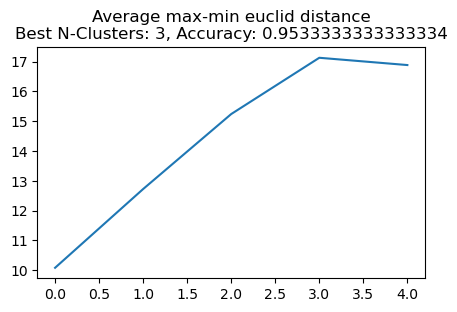

In [232]:
df = pd.DataFrame(result)
index = df["Max-min"].argmax()
best = df["N-Clusters"][index]
acc = df["Mapping-Accuray"][index]
plt.figure(figsize=(5, 3))
plt.plot(df["Iter"], df["Max-min"])
plt.title(
    "Average max-min euclid distance\n"
    f"Best N-Clusters: {best}, Accuracy: {acc}"
)